# 1.このSprintについて

Sprintの目的
- スクラッチを通してK-meansを理解する
- クラスタ分析を行う

どのように学ぶか
- スクラッチでK-meansを実装した後、それを使用しクラスタ分析を行います。

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance

In [2]:
# シンプルデータセット3
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [158]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        mu_list = []       # 中心点保持用
        sse_list = []      # sse保持用
        cluster_list = []  # クラスタ保持用
        
        # n_init回行う処理
        for i in range(self.n_init):
            mu = self._initial_mu(X, self.n_clusters)
            
            # max_iter回行う処理
            for j in range(self.max_iter):
                
                # クラスタ割り当て
                cluster = self._assign(X, mu)
                
                # 重心移動と移動距離
                mu, dif = self._move_mu(X, mu, cluster)
                
                # sse算出
                sse = self._sse(X, mu)
                
                # 移動距離が tol 以下の場合、強制終了。
                if np.max(dif) < self.tol:
                    break

            # 各値の保持
            mu_list.append(mu)
            sse_list.append(sse)
            cluster_list.append(cluster)
            
            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                print(f'sse:{round(sse, 1)}, n_init:{i}, max_iter:{j}')

        # sseが最も小さかった時の中心点とsseをインスタンス変数化
        self.mu = mu_list[np.argmin(sse_list)]
        self.sse = self._sse(X, self.mu)
    
    def _initial_mu(self, X, n_clusters):
        '''
        中心点の初期値を決める
        '''
        pos = np.random.choice(len(X), n_clusters, replace=False)

        return X[pos, :]
    
    def _sse(self, X, mu):
        '''
        SSEを求める関数の作成
        '''
        euclidean = distance.cdist(X, mu, metric='euclidean')

        return euclidean.min(axis=1).sum()

    def _assign(self, X, mu):
        '''
        クラスタの割り当て
        '''
        distance = np.ones((len(X), len(mu)))
        for i in range(len(mu)):
            distance[:, i] = np.linalg.norm(X - mu[i], axis=1)

        return np.argmin(distance, axis=1)

    def _move_mu(self, X, mu, cluster_num):
        '''
        中心の移動
        '''
        new_mu = np.ones(mu.shape)
        for k in set(cluster_num):
            new_mu[k] = np.mean(X[cluster_num==k], axis=0)

        return new_mu, np.linalg.norm(mu - new_mu, axis=1)

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        return self._assign(X, self.mu)

# 【問題1】中心点の初期値を決める
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。  
最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。  
K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [248]:
n_clusters = 4

def _initial_mu(X, n_clusters):
    pos = np.random.choice(len(X), n_clusters, replace=False)
    
    return X[pos, :]

In [249]:
mu = _initial_mu(X, n_clusters)
mu

array([[ 1.46870582,  1.86947425],
       [-1.43284669,  7.71577043],
       [-0.8623605 ,  8.24721209],
       [-1.74448079,  3.84251413]])

# 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。

K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$

$n$ : データ点のインデックス  
$k$ : クラスタのインデックス  
$X_n$ : $n$番目のデータ点  
$\mu_k$ : $k$番目の中心点  

$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0  

In [265]:
# scipyで距離行列を作る
from scipy.spatial import distance

def _sse(X, mu):
    euclidean = distance.cdist(X, mu, metric='euclidean')

    return euclidean.min(axis=1).sum()

In [ ]:
    def SSE(self, X, mu, R):
        m = X.shape[0]
        k = mu.shape[0] 
        X_2 = np.sum(X**2, axis=1)[:, np.newaxis]
        mu_2 = np.sum(mu**2, axis=1)
        # X|^2 , |μ|^2を並べる
        XX = np.tile(X_2, (1, k))
        mumu = np.tile(mu_2, (m, 1))
        # 両者を加え、2X・μを引く
        Z = XX + mumu - 2*(X@mu.T)
        # クラス判別行列Rをかけて出力
        return sum(sum(Z*R))   

In [251]:
_sse(X, mu)

123.14139228901593

# 【問題3】クラスタへの割り当て
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。  
K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。  
NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。  

In [252]:
def _assign(X, mu):
    distance = np.ones((len(X), len(mu)))
    for k in range(len(mu)):
        distance[:, k] = np.linalg.norm(X - mu[k], axis=1)
    
    return np.argmin(distance, axis=1)

In [253]:
cluster = _assign(X, mu)
cluster

array([0, 1, 0, 0, 0, 0, 3, 2, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 0, 1,
       3, 0, 3, 3, 3, 0, 0, 0, 0, 1, 0, 0, 3, 0, 2, 0, 2, 3, 3, 3, 1, 3,
       3, 1, 0, 3, 0, 0, 3, 0, 3, 3, 3, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 2, 3, 3, 0, 3, 0, 0,
       0, 0, 0, 3, 0, 3, 3, 1, 1, 3, 2, 3])

# 【問題4】中心点の移動
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。  
クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [254]:
def _move_mu(X, mu, cluster_num):
    new_mu = np.ones(mu.shape)
    for k in set(cluster_num):
        new_mu[k] = np.mean(X[cluster_num==k], axis=0)
    
    return new_mu, np.linalg.norm(mu - new_mu, axis=1)

In [255]:
mu, dif = _move_mu(X, mu, cluster)

# 中心点と重心の差分
dif

array([0.51362333, 0.19266298, 0.0331113 , 0.74048244])

In [256]:
cluster = _assign(X, mu)
cluster

array([0, 1, 0, 0, 0, 0, 3, 2, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 0, 1,
       3, 0, 3, 3, 3, 3, 0, 0, 0, 1, 0, 0, 3, 0, 2, 0, 2, 3, 3, 3, 1, 3,
       3, 1, 0, 3, 0, 0, 3, 0, 3, 3, 3, 1, 2, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 2, 3, 3, 0, 3, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 1, 1, 3, 2, 3])

# 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  
次のどれかの条件を満たしたらこれを止めます。  
- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）  
- 中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

In [257]:
max_iter = 4
n_clusters = 10
mu = _initial_mu(X, n_clusters)
tol = 1e-5

In [258]:
for i in range(max_iter):
    # 割当
    cluster = _assign(X, mu)
    mu, dif = _move_mu(X, mu, cluster)
    
    if np.max(dif) < tol:
        break

# 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。  
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。

In [259]:
n_init = 5

In [260]:
mu_list = []
sse_list = []
cluster_list = []
for i in range(n_init):
    mu = _initial_mu(X, n_clusters)
    for _ in range(max_iter):
        cluster = _assign(X, mu)
        mu, dif = _move_mu(X, mu, cluster)
        sse = _sse(X, mu)      
        if np.max(dif) < tol:
            break
    
    mu_list.append(mu)
    sse_list.append(sse)
    cluster_list.append(cluster)

mu = mu_list[np.argmin(sse_list)]
cluster = cluster_list[np.argmin(sse_list)]

# 【問題7】推定
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。


- データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。

具体的には次のことです。


- データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。

## ・スクラッチによる実装

In [261]:
# 学習
skm1 = ScratchKMeans(n_clusters=4, n_init=10, max_iter=10, tol=1e-5, verbose=True)
skm1.fit(X)

# 推定
pred1 = skm1.predict(X)
pred1

sse:62.6, n_init:0, max_iter:5
sse:99.7, n_init:1, max_iter:6
sse:100.6, n_init:2, max_iter:3
sse:100.1, n_init:3, max_iter:3
sse:62.6, n_init:4, max_iter:1
sse:62.6, n_init:5, max_iter:2
sse:62.6, n_init:6, max_iter:4
sse:62.6, n_init:7, max_iter:3
sse:62.6, n_init:8, max_iter:5
sse:62.6, n_init:9, max_iter:6


array([1, 3, 1, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 2, 1, 3,
       0, 2, 1, 0, 0, 1, 2, 2, 2, 3, 2, 2, 0, 1, 3, 2, 3, 0, 1, 0, 3, 0,
       0, 3, 2, 0, 1, 1, 1, 2, 0, 0, 0, 3, 3, 2, 2, 3, 3, 2, 2, 1, 2, 3,
       0, 0, 2, 1, 3, 2, 1, 3, 1, 1, 0, 0, 2, 2, 2, 3, 0, 1, 2, 0, 2, 2,
       1, 1, 1, 0, 1, 0, 0, 3, 3, 0, 3, 1])

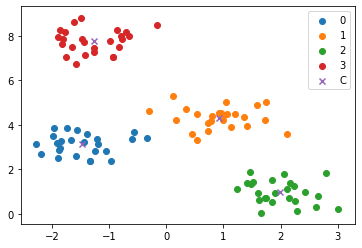

In [262]:
# 可視化
Xn = []
for i in set(pred1):
    Xn.append(X[pred1 == i])
    plt.scatter(Xn[i][:, 0], Xn[i][:, 1], label=i)
plt.scatter(skm1.mu[:, 0], skm1.mu[:, 1], marker='x', label='C')
plt.legend();

## ・未知のデータに対して分類

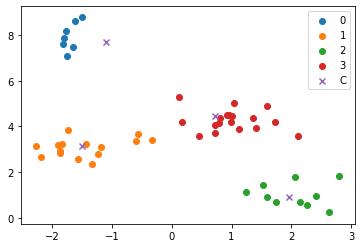

In [263]:
# 訓練データと検証データに分割
ind = np.random.choice(len(X), len(X), replace=False)
X_train = X[ind[:50]]
X_test = X[ind[50:]]

# 学習と推定
skm2 = ScratchKMeans(n_clusters=4, n_init=10, max_iter=10, tol=1e-5, verbose=False)
skm2.fit(X_train)
pred2 = skm2.predict(X_test)

# 可視化
Xn = []
for i in set(pred2):
    Xn.append(X_test[pred2 == i])
    plt.scatter(Xn[i][:, 0], Xn[i][:, 1], label=i)
plt.scatter(skm2.mu[:, 0], skm2.mu[:, 1], marker='x', label='C')
plt.legend();

## ・sklearnによる実装

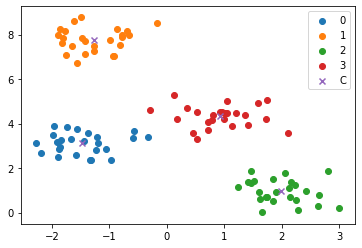

In [169]:
from sklearn.cluster import KMeans

# 学習
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=10, tol=1e-5)
kmeans.fit(X)

# 推定
pred_sk = kmeans.predict(X)

# 可視化
Xn = []
for i in set(pred_sk):
    Xn.append(X[pred_sk == i])
    plt.scatter(Xn[i][:, 0], Xn[i][:, 1], label=i)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', label='C')
plt.legend();

# 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。

SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

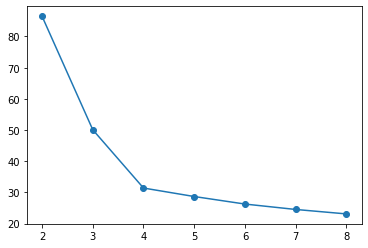

In [173]:
sse_list = []
k = 8
for i in range(2, k+1):
    skm = ScratchKMeans(n_clusters=i, n_init=10, max_iter=10, tol=1e-5, verbose=False)
    skm.fit(X_train)
    sse_list.append(skm.sse)

plt.plot([i for i in range(2, k+1)], sse_list, marker='o');

# 3.クラスタ分析

In [23]:
data = pd.read_csv('../kaggledata/Wholesale customers data.csv')
data = data.iloc[:, 2:]
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [24]:
# 対数変換
data = np.log(data)

# 標準化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(data)
data = ss.transform(data)

In [25]:
# 次元削除
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

In [26]:
data_pca[:5]

array([[-1.37937462,  0.30383791],
       [-1.43480713, -0.53814669],
       [-1.50395108, -1.22615334],
       [ 0.82413256, -1.20577046],
       [-0.79738815, -1.75698625]])

[0.43990911 0.71118573 0.81875328 0.92020054 0.96926786 1.        ]


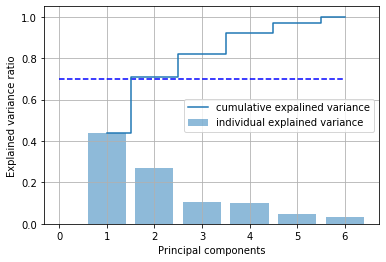

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

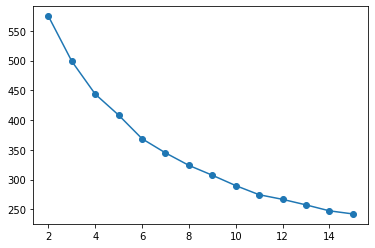

In [264]:
sse_list = []
k = 15
for i in range(2, k+1):
    skm3 = ScratchKMeans(n_clusters=i, n_init=10, max_iter=10, tol=1e-5, verbose=False)
    skm3.fit(data_pca)
    sse_list.append(skm3.sse)

plt.plot([i for i in range(2, k+1)], sse_list, marker='o');

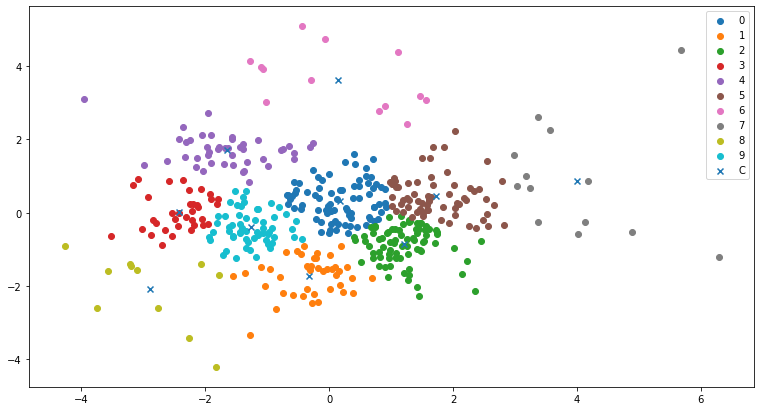

In [29]:
# 学習と推定
skm4 = ScratchKMeans(n_clusters=10, n_init=100, max_iter=100, tol=1e-5, verbose=False)
skm4.fit(data_pca)
pred4 = skm4.predict(data_pca)

# 可視化
Xn = []
plt.figure(figsize=(13, 7))
for i in set(pred4):
    Xn.append(data_pca[pred4 == i])
    plt.scatter(Xn[i][:, 0], Xn[i][:, 1], label=i)
plt.scatter(skm4.mu[:, 0], skm4.mu[:, 1], marker='x', label='C')
plt.legend();

>これであれば平均的な買い方をする人と買い方に癖がある人を区別しやすい。

# 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

In [30]:
data = pd.read_csv('../kaggledata/Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


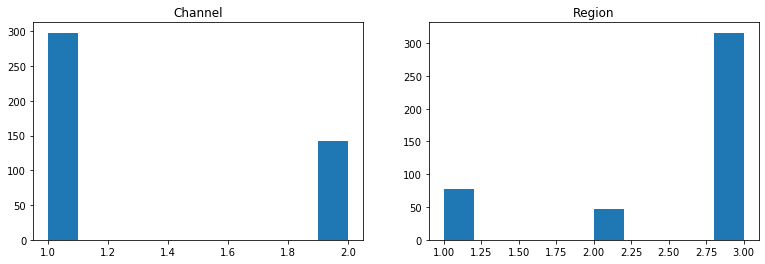

In [31]:
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.title('Channel')
plt.hist(data['Channel'])
plt.subplot(122)
plt.title('Region')
plt.hist(data['Region']);

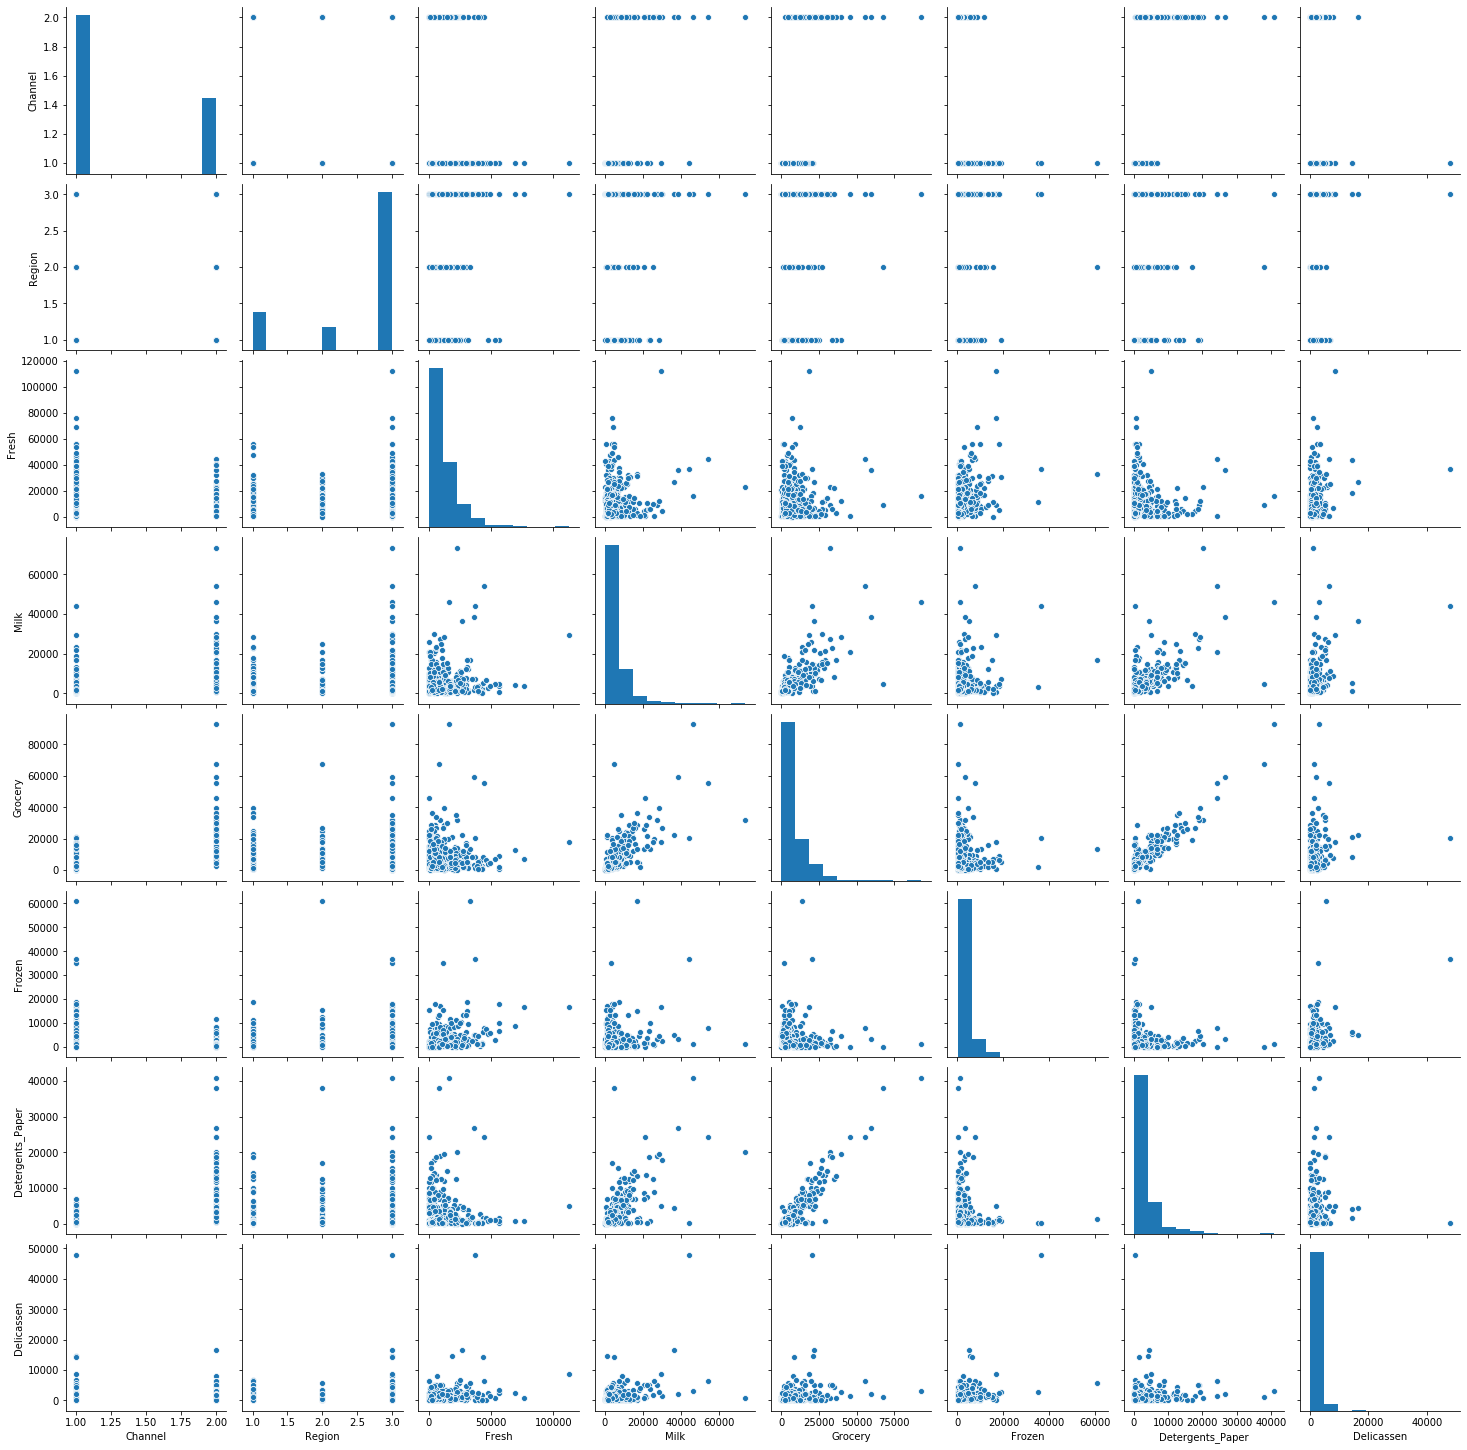

In [32]:
sns.pairplot(data);

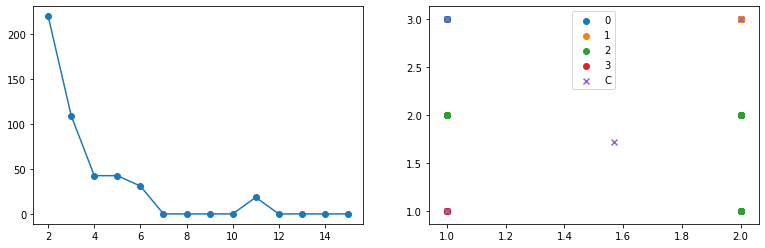

In [273]:
sse_list = []
k = 15
for i in range(2, k+1):
    skm5 = ScratchKMeans(n_clusters=i, n_init=10, max_iter=10, tol=1e-5, verbose=False)
    skm5.fit(np.array(data.iloc[:, :2]))
    sse_list.append(skm5.sse)

plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.plot([i for i in range(2, k+1)], sse_list, marker='o')

# 学習と推定
skm6 = ScratchKMeans(n_clusters=4, n_init=100, max_iter=100, tol=1e-5, verbose=False)
skm6.fit(np.array(data.iloc[:, :2]))
pred6 = skm6.predict(np.array(data.iloc[:, :2]))

# 可視化
Xn = []
plt.subplot(122)
for i in set(pred6):
    Xn.append(np.array(data.iloc[:, :2])[pred6 == i])
    plt.scatter(Xn[i][:, 0], Xn[i][:, 1], label=i)
plt.scatter(skm6.mu[:, 0], skm6.mu[:, 1], marker='x', label='C')
plt.legend();

>既にChannelとRegionは分類されたデータであるためクラスタリングは適さない。

# 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

In [48]:
data = pd.read_csv('../kaggledata/Wholesale customers data.csv')
data = data.iloc[:, 2:]
data['cluster'] = pred4

In [49]:
# 平均的に購入する顧客と買い方に癖がある顧客に分ける。
data['cluster'][(data['cluster']==6)] = 11
data['cluster'][(data['cluster']==7)] = 12
data['cluster'][(data['cluster']==8)] = 13
data['cluster'][(data['cluster']==0) | (data['cluster']==4) | 
                (data['cluster']==1) | (data['cluster']==5) |
                (data['cluster']==2) | (data['cluster']==9) |
                (data['cluster']==3)] = 14

In [50]:
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,14
1,7057,9810,9568,1762,3293,1776,14
2,6353,8808,7684,2405,3516,7844,14
3,13265,1196,4221,6404,507,1788,14
4,22615,5410,7198,3915,1777,5185,14


In [51]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,13.827273
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,0.616539
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,11.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,14.000000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,14.000000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,14.000000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,14.000000


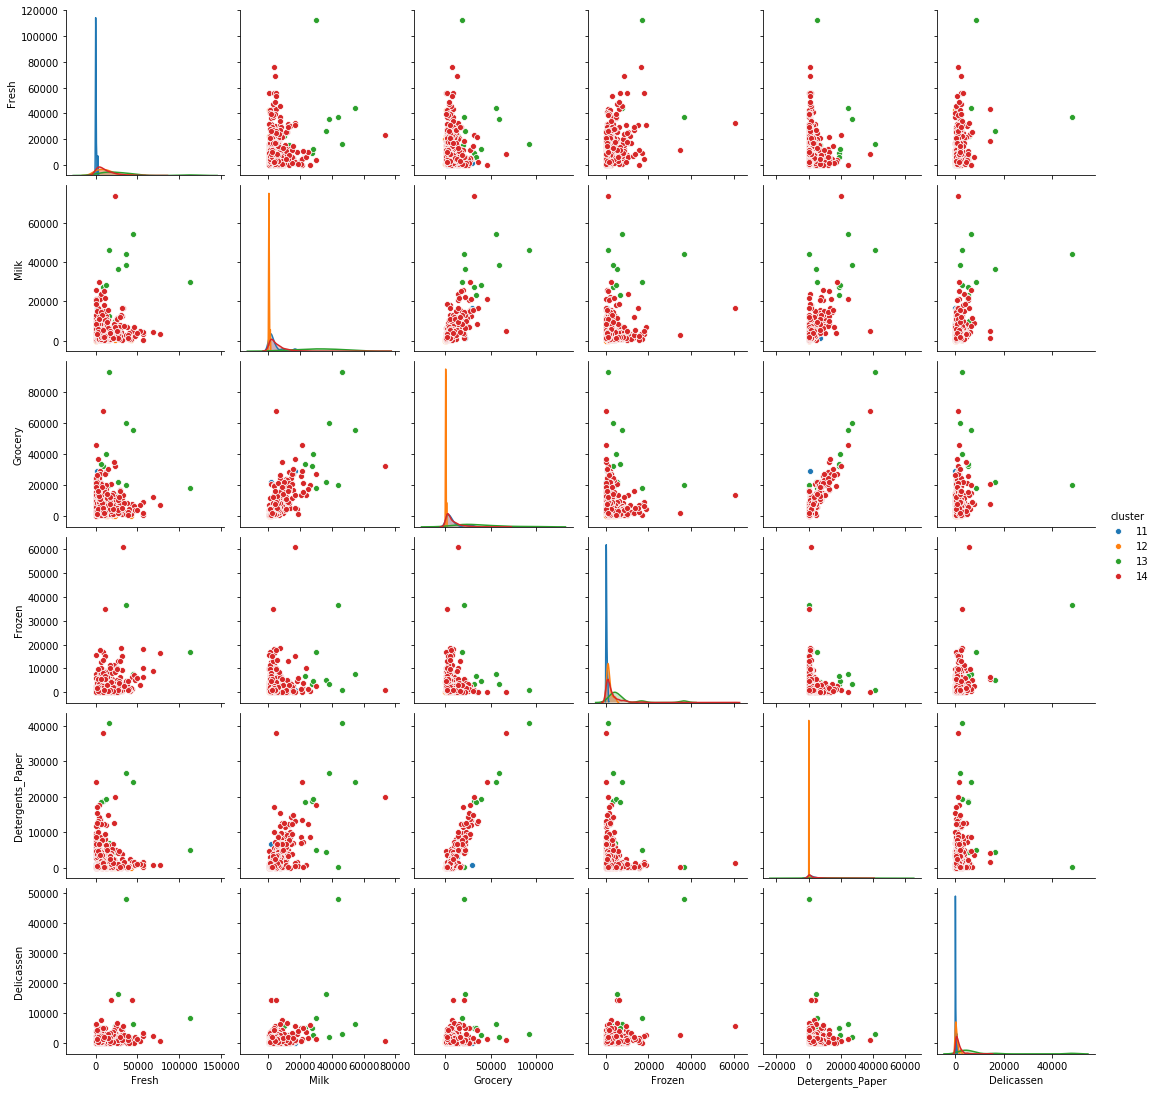

In [52]:
sns.pairplot(data, hue='cluster');

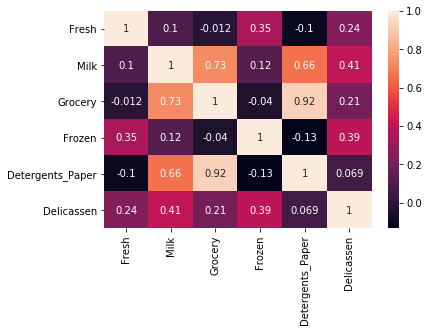

In [53]:
sns.heatmap(data.iloc[:, :-1].corr(), annot=True);

>ミルクとGrocery、Detergents_Paperの相関が高い。

In [196]:
data_cluster = data.groupby('cluster').sum().reset_index()
data_cluster

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,11,7010,47417,106092,3864,21828,1605
1,12,154912,4761,6197,19293,459,6406
2,13,337609,350185,407250,92549,169723,105720
3,14,4780600,2147994,2979023,1235944,1075847,557212


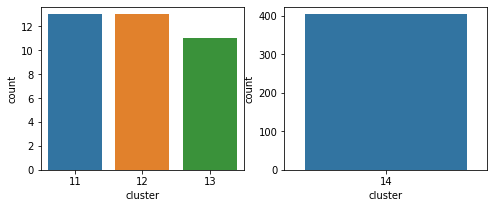

In [197]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
sns.countplot(data['cluster'][data['cluster']!=14])
plt.subplot(122)
sns.countplot(data['cluster'][data['cluster']==14]);

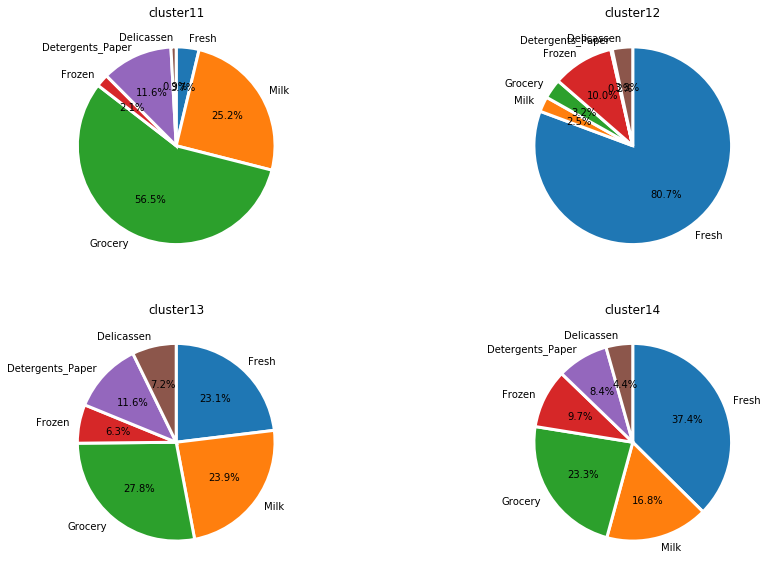

In [198]:
plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(f'cluster{i+11}')
    plt.pie(data_cluster.iloc[i, 1:], 
            labels=data_cluster.iloc[0, 1:].index, 
            counterclock=False, 
            startangle=90, 
            autopct='%.1f%%',
            wedgeprops={'linewidth': 3, 'edgecolor':"white"})

>11のクラスタはGroceryに偏りがあり、12のクラスタはFreshに偏っている。  
13はバランスよく購入している。14はFreshが40%弱を占めている。

### グループ別の購入単価

In [202]:
data_cluster['顧客数'] = data['cluster'].value_counts().sort_index().values

li = []
for i in range(len(data_cluster)):
    li.append(data_cluster.iloc[i, 1:-1].sum() / data_cluster['顧客数'].iloc[i])
    
data_cluster['単価'] = list(map(int, li))
data_cluster

,cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,顧客数,単価
0,11,7010,47417,106092,3864,21828,1605,13,14448
1,12,154912,4761,6197,19293,459,6406,13,14772
2,13,337609,350185,407250,92549,169723,105720,11,133004
3,14,4780600,2147994,2979023,1235944,1075847,557212,403,31704


>13のクラスタは高単価。